<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo Fin de Master</header1></center>
<left><h1>Análisis y visualización espacio-temporal del riesgo delictivo mediante aprendizaje automático.</header1></left>

Presentado por: Dimas Enrique Colón Cera - Victor Hernan del Toro <br>
Fecha: 31/01/2026

In [1]:
#carga de librerias
import pandas as pd
import matplotlib.pyplot as plt
import folium

In [3]:
#carga de datos
ruta = r"C:\Users\dimas\OneDrive\Escritorio\Crime_Data_from_2020_to_real.csv"
data = pd.read_csv(ruta)

In [5]:
#informacion de dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non-null  int64  
 9   Crm Cd Desc     1004991 non-null  object 
 10  Mocodes         853372 non-null   object 
 11  Vict Age        1004991 non-null  int64  
 12  Vict Sex        860347 non-null   object 
 13  Vict Descent    860335 non-null   object 
 14  Premis Cd       1004975 non-null  float64
 15  Premis Desc     1004403 non-null  object 
 16  Weapon Used Cd  327247 non-null   fl

##### 1.Cambiar el  nombre de las columnas

In [8]:
data = data.rename(columns={
    "DR_NO": "reporte_id",
    "Date Rptd": "fecha_reportado",
    "DATE OCC": "fecha_ocurrencia",
    "TIME OCC": "hora_ocurrencia",

    "AREA": "area_codigo",
    "AREA NAME": "area_nombre",
    "Rpt Dist No": "distrito_policial",

    "Part 1-2": "categoria_delito",
    "Crm Cd": "codigo_delito",
    "Crm Cd Desc": "descripcion_delito",
    "Mocodes": "modus_operandi",

    "Vict Age": "victima_edad",
    "Vict Sex": "victima_sexo",
    "Vict Descent": "victima_descendencia",

    "Premis Cd": "premisa_codigo",
    "Premis Desc": "premisa_descripcion",

    "Weapon Used Cd": "arma_codigo",
    "Weapon Desc": "arma_descripcion",

    "Status": "estado_codigo",
    "Status Desc": "estado_descripcion",

    "Crm Cd 1": "delito_1",
    "Crm Cd 2": "delito_2",
    "Crm Cd 3": "delito_3",
    "Crm Cd 4": "delito_4",

    "LOCATION": "direccion",
    "Cross Street": "calle_transversal",
    "LAT": "latitud",
    "LON": "longitud"
   })

In [10]:
data.head(2)

reporte_id         fecha_reportado        fecha_ocurrencia  \
0   211507896  04/11/2021 12:00:00 AM  11/07/2020 12:00:00 AM   
1   201516622  10/21/2020 12:00:00 AM  10/18/2020 12:00:00 AM   

   hora_ocurrencia  area_codigo  area_nombre  distrito_policial  \
0              845           15  N Hollywood               1502   
1             1845           15  N Hollywood               1521   

   categoria_delito  codigo_delito  \
0                 2            354   
1                 1            230   

                               descripcion_delito  ... estado_codigo  \
0                               THEFT OF IDENTITY  ...            IC   
1  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...            IC   

   estado_descripcion delito_1 delito_2  delito_3 delito_4  \
0         Invest Cont    354.0      NaN       NaN      NaN   
1         Invest Cont    230.0      NaN       NaN      NaN   

                                 direccion calle_transversal  latitud  \
0  7800    BEEMAN                       AV               NaN  34.2124   
1          ATOLL                        AV          N  GAULT  34.1993   

   longitud  
0 -118.4092  
1 -118.4203  

[2 rows x 28 columns]

##### 2.Agrupación de los delitos en categorías a través de sus descripciones.

In [13]:
import pandas as pd

def procesar_categorias(
    data,
    columna_original="descripcion_delito",
    exportar_excel=True,
    nombre_excel="categorias_resumen.xlsx"
):
    """
    1) Crea la columna 'Categoria_Delictiva' a partir de 'columna_original'
       usando un diccionario de mapeo.
    2) Calcula cantidad y porcentaje por categoría.
    3) Devuelve TODAS las categorías (sin umbral).
    4) Opcional: exporta la tabla a Excel.
    """

    CRIME_MAPPING_ES = {
        "THEFT OF IDENTITY": "Robo de Identidad",
        "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT": "Agresiones Violentas",
        "THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)": "Hurto desde Vehículo",
        "THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)": "Hurto desde Vehículo",
        "CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)": "Delitos Sexuales",
        "VEHICLE - STOLEN": "Robo de Vehículo",
        "BURGLARY": "Allanamiento Residencial",
        "BURGLARY FROM VEHICLE": "Allanamiento de Vehículo",
        "THEFT PLAIN - PETTY ($950 & UNDER)": "Hurto General",
        "INTIMATE PARTNER - SIMPLE ASSAULT": "Violencia de Pareja",
        "BATTERY - SIMPLE ASSAULT": "Agresiones Físicas",
        "VANDALISM - MISDEAMEANOR ($399 OR UNDER)": "Daños a la Propiedad",
        "VEHICLE - ATTEMPT STOLEN": "Robo de Vehículo",
        "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)": "Daños a la Propiedad",
        "ROBBERY": "Robo con Violencia",
        "FIREARMS RESTRAINING ORDER (FIREARMS RO)": "Incumplimientos Judiciales",
        "BIKE - STOLEN": "Robo de Vehículo",
        "EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)": "Fraude y Delitos Financieros",
        "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT": "Agresiones Violentas",
        "CRIMINAL THREATS - NO WEAPON DISPLAYED": "Amenazas y Coerción",
        "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD": "Hurto Económico",
        "BATTERY WITH SEXUAL CONTACT": "Delitos Sexuales",
        "LETTERS, LEWD  -  TELEPHONE CALLS, LEWD": "Delitos Sexuales",
        "VIOLATION OF COURT ORDER": "Incumplimientos Judiciales",
        "ARSON": "Daños a la Propiedad",
        "VIOLATION OF RESTRAINING ORDER": "Incumplimientos Judiciales",
        "THEFT, PERSON": "Hurto General",
        "CONTEMPT OF COURT": "Incumplimientos Judiciales",
        "INTIMATE PARTNER - AGGRAVATED ASSAULT": "Violencia de Pareja",
        "ATTEMPTED ROBBERY": "Robo con Violencia",
        "LEWD/LASCIVIOUS ACTS WITH CHILD": "Delitos Sexuales",
        "OTHER MISCELLANEOUS CRIME": "Alteración del Orden Público",
        "BRANDISH WEAPON": "Delitos con Armas",
        "TRESPASSING": "Alteración del Orden Público",
        "BUNCO, ATTEMPT": "Fraude y Delitos Financieros",
        "SHOPLIFTING - PETTY THEFT ($950 & UNDER)": "Robo en Tiendas",
        "BURGLARY, ATTEMPTED": "Allanamiento Residencial",
        "DOCUMENT FORGERY / STOLEN FELONY": "Fraude y Delitos Financieros",
        "SHOPLIFTING-GRAND THEFT ($950.01 & OVER)": "Robo en Tiendas",
        "FAILURE TO YIELD": "Alteración del Orden Público",
        "BATTERY POLICE (SIMPLE)": "Agresiones Físicas",
        "VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)": "Robo de Vehículo",
        "CHILD NEGLECT (SEE 300 W.I.C.)": "Delitos contra Menores",
        "RAPE, ATTEMPTED": "Delitos Sexuales",
        "BUNCO, GRAND THEFT": "Fraude y Delitos Financieros",
        "CONTRIBUTING": "Delitos contra Menores",
        "PIMPING": "Delitos Sexuales",
        "OTHER ASSAULT": "Agresiones Violentas",
        "SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH": "Delitos Sexuales",
        "RAPE, FORCIBLE": "Delitos Sexuales",
        "SEX OFFENDER REGISTRANT OUT OF COMPLIANCE": "Incumplimientos Judiciales",
        "DISCHARGE FIREARMS/SHOTS FIRED": "Disparos de Arma de Fuego",
        "EXTORTION": "Amenazas y Coerción",
        "SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT": "Disparos de Arma de Fuego",
        "ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER": "Agresiones Violentas",
        "BUNCO, PETTY THEFT": "Fraude y Delitos Financieros",
        "RESISTING ARREST": "Alteración del Orden Público",
        "VIOLATION OF TEMPORARY RESTRAINING ORDER": "Incumplimientos Judiciales",
        "CHILD ANNOYING (17YRS & UNDER)": "Delitos contra Menores",
        "SHOTS FIRED AT INHABITED DWELLING": "Disparos de Arma de Fuego",
        "BURGLARY FROM VEHICLE, ATTEMPTED": "Allanamiento de Vehículo",
        "THROWING OBJECT AT MOVING VEHICLE": "Alteración del Orden Público",
        "SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ": "Delitos Sexuales",
        "ORAL COPULATION": "Delitos Sexuales",
        "SEXUAL PENETRATION W/FOREIGN OBJECT": "Delitos Sexuales",
        "LEWD CONDUCT": "Delitos Sexuales",
        "PICKPOCKET": "Hurto General",
        "CHILD STEALING": "Delitos contra Menores",
        "PURSE SNATCHING": "Robo con Violencia",
        "THEFT FROM MOTOR VEHICLE - ATTEMPT": "Hurto desde Vehículo",
        "HUMAN TRAFFICKING - COMMERCIAL SEX ACTS": "Delitos Sexuales",
        "INDECENT EXPOSURE": "Delitos Sexuales",
        "DISHONEST EMPLOYEE - PETTY THEFT": "Fraude y Delitos Financieros",
        "EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)": "Fraude y Delitos Financieros",
        "KIDNAPPING": "Delito Violento",
        "DISTURBING THE PEACE": "Alteración del Orden Público",
        "UNAUTHORIZED COMPUTER ACCESS": "Fraude y Delitos Financieros",
        "CRIMINAL HOMICIDE": "Homicidio",
        "THEFT PLAIN - ATTEMPT": "Hurto General",
        "REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)": "Delitos con Armas",
        "LYNCHING": "Agresiones Violentas",
        "RECKLESS DRIVING": "Alteración del Orden Público",
        "THREATENING PHONE CALLS/LETTERS": "Amenazas y Coerción",
        "SHOPLIFTING - ATTEMPT": "Robo en Tiendas",
        "BOMB SCARE": "Alteración del Orden Público",
        "CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT": "Agresiones Violentas",
        "STALKING": "Amenazas y Coerción",
        "DRIVING WITHOUT OWNER CONSENT (DWOC)": "Robo de Vehículo",
        "BATTERY ON A FIREFIGHTER": "Agresiones Físicas",
        "PEEPING TOM": "Delitos Sexuales",
        "FALSE POLICE REPORT": "Incumplimientos Judiciales",
        "BOAT - STOLEN": "Robo de Vehículo",
        "DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER": "Fraude y Delitos Financieros",
        "ILLEGAL DUMPING": "Alteración del Orden Público",
        "DRUGS, TO A MINOR": "Delitos contra Menores",
        "THEFT, COIN MACHINE - PETTY ($950 & UNDER)": "Hurto Económico",
        "CREDIT CARDS, FRAUD USE ($950 & UNDER": "Fraude y Delitos Financieros",
        "MANSLAUGHTER, NEGLIGENT": "Homicidio",
        "THEFT FROM PERSON - ATTEMPT": "Hurto General",
        "KIDNAPPING - GRAND ATTEMPT": "Delito Violento",
        "THEFT, COIN MACHINE - ATTEMPT": "Hurto Económico",
        "PETTY THEFT - AUTO REPAIR": "Hurto Económico",
        "DOCUMENT WORTHLESS ($200 & UNDER)": "Fraude y Delitos Financieros",
        "FALSE IMPRISONMENT": "Delito Violento",
        "CREDIT CARDS, FRAUD USE ($950.01 & OVER)": "Fraude y Delitos Financieros",
        "DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01": "Fraude y Delitos Financieros",
        "CHILD PORNOGRAPHY": "Delitos Sexuales",
        "PANDERING": "Delitos Sexuales",
        "HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE": "Delitos Sexuales",
        "CRUELTY TO ANIMALS": "Alteración del Orden Público",
        "COUNTERFEIT": "Fraude y Delitos Financieros",
        "DISHONEST EMPLOYEE - GRAND THEFT": "Fraude y Delitos Financieros",
        "PROWLER": "Alteración del Orden Público",
        "DOCUMENT WORTHLESS ($200.01 & OVER)": "Fraude y Delitos Financieros",
        "WEAPONS POSSESSION/BOMBING": "Delitos con Armas",
        "GRAND THEFT / AUTO REPAIR": "Hurto Económico",
        "CONSPIRACY": "Otros",
        "DRUNK ROLL": "Hurto General",
        "LYNCHING - ATTEMPTED": "Agresiones Violentas",
        "THEFT, COIN MACHINE - GRAND ($950.01 & OVER)": "Hurto Económico",
        "DISRUPT SCHOOL": "Alteración del Orden Público",
        "TILL TAP - PETTY ($950 & UNDER)": "Hurto Económico",
        "PICKPOCKET, ATTEMPT": "Hurto General",
        "GRAND THEFT / INSURANCE FRAUD": "Fraude y Delitos Financieros",
        "TILL TAP - GRAND THEFT ($950.01 & OVER)": "Hurto Económico",
        "PURSE SNATCHING - ATTEMPT": "Robo con Violencia",
        "BIKE - ATTEMPTED STOLEN": "Robo de Vehículo",
        "BRIBERY": "Fraude y Delitos Financieros",
        "CHILD ABANDONMENT": "Delitos contra Menores",
        "TELEPHONE PROPERTY - DAMAGE": "Daños a la Propiedad",
        "BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM": "Delitos Sexuales",
        "BIGAMY": "Otros",
        "FAILURE TO DISPERSE": "Alteración del Orden Público",
        "FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)": "Incumplimientos Judiciales",
        "INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)": "Delitos Sexuales",
        "BLOCKING DOOR INDUCTION CENTER": "Alteración del Orden Público",
        "INCITING A RIOT": "Alteración del Orden Público",
        "DISHONEST EMPLOYEE ATTEMPTED THEFT": "Fraude y Delitos Financieros",
        "TRAIN WRECKING": "Delito Violento",
        "DRUNK ROLL - ATTEMPT": "Hurto General"
    }

     # 1) Crear la categoría agrupada
    data["Categoria_Delictiva"] = (
        data[columna_original]
        .map(CRIME_MAPPING_ES)
        .fillna("Otros")
    )

    # 2) Tabla resumen
    resumen = (
        data["Categoria_Delictiva"]
        .value_counts()
        .to_frame(name="Cantidad")
    )

    resumen["Porcentaje"] = (
        resumen["Cantidad"] / resumen["Cantidad"].sum() * 100
    )

    # 3) Exportar a excel
    if exportar_excel:
        resumen.to_excel(nombre_excel)
        print(f"Archivo exportado como: {nombre_excel}")

    return resumen

In [15]:
resumen = procesar_categorias(
    data=data,
    columna_original="descripcion_delito"
)

Archivo exportado como: categorias_resumen.xlsx


##### 3. Preparar las variables para  el análisis. 

In [18]:
def preparar_fechas_y_tiempo(data):
    """
    Limpia y prepara todas las variables de fecha y hora del dataset LAPD.
    Convierte fechas al formato MM/DD/YYYY y crea variables temporales
    útiles para modelado criminológico.
    """

    # -----------------------------
    # 1. Convertir fechas al formato correcto (tu formato real)
    # -----------------------------
    data["fecha_ocurrencia"] = pd.to_datetime(
        data["fecha_ocurrencia"],
        format="%m/%d/%Y %I:%M:%S %p",
        errors="coerce"
    )
    
    data["fecha_reportado"] = pd.to_datetime(
        data["fecha_reportado"],
        format="%m/%d/%Y %I:%M:%S %p",
        errors="coerce"
    )

    # -----------------------------
    # 2. Crear columnas básicas de fecha
    # -----------------------------
    data["year"] = data["fecha_ocurrencia"].dt.year
    data["month"] = data["fecha_ocurrencia"].dt.month
    data["day"] = data["fecha_ocurrencia"].dt.day
    data["weekday"] = data["fecha_ocurrencia"].dt.weekday
    data["weekday_name"] = data["fecha_ocurrencia"].dt.day_name()
    data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

    # -----------------------------
    # 3. Limpiar y transformar hora_ocurrencia
    #     Ej: 845 → 8,   1845 → 18
    # -----------------------------
    data["hora_ocurrencia"] = pd.to_numeric(data["hora_ocurrencia"], errors="coerce")
    data["hora_entera"] = (data["hora_ocurrencia"] // 100).astype("Int64")

    # -----------------------------
    # 4. Crear franjas criminológicas
    # -----------------------------
    import numpy as np
    
    condiciones = [
        (data["hora_entera"] >= 0) & (data["hora_entera"] < 6),
        (data["hora_entera"] >= 6) & (data["hora_entera"] < 12),
        (data["hora_entera"] >= 12) & (data["hora_entera"] < 18),
        (data["hora_entera"] >= 18) & (data["hora_entera"] <= 23),
    ]

    valores = ["Madrugada", "Mañana", "Tarde", "Noche"]
    data["Franja_Horaria"] = np.select(condiciones, valores, default="Desconocida")

    # -----------------------------
    # 5. Convertir fechas al formato MM/DD/YYYY (string final)
    # -----------------------------
    data["fecha_ocurrencia"] = data["fecha_ocurrencia"].dt.strftime("%m/%d/%Y")
    data["fecha_reportado"] = data["fecha_reportado"].dt.strftime("%m/%d/%Y")

    return data


In [20]:
data = preparar_fechas_y_tiempo(data)

In [22]:
time_str = data['hora_ocurrencia'].astype(str).str.zfill(4)
data['hora_ocurrencia_HHMM'] = time_str.str[:2] + ':' + time_str.str[2:]

In [24]:
data.head()

reporte_id fecha_reportado fecha_ocurrencia  hora_ocurrencia  area_codigo  \
0   211507896      04/11/2021       11/07/2020              845           15   
1   201516622      10/21/2020       10/18/2020             1845           15   
2   240913563      12/10/2024       10/30/2020             1240            9   
3   210704711      12/24/2020       12/24/2020             1310            7   
4   201418201      10/03/2020       09/29/2020             1830           14   

   area_nombre  distrito_policial  categoria_delito  codigo_delito  \
0  N Hollywood               1502                 2            354   
1  N Hollywood               1521                 1            230   
2     Van Nuys                933                 2            354   
3     Wilshire                782                 1            331   
4      Pacific               1454                 1            420   

                                  descripcion_delito  ...  \
0                                  THEFT OF IDENTITY  ...   
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...   
2                                  THEFT OF IDENTITY  ...   
3  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...  ...   
4    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)  ...   

    Categoria_Delictiva  year month day  weekday weekday_name  is_weekend  \
0     Robo de Identidad  2020    11   7        5     Saturday           1   
1  Agresiones Violentas  2020    10  18        6       Sunday           1   
2     Robo de Identidad  2020    10  30        4       Friday           0   
3  Hurto desde Vehículo  2020    12  24        3     Thursday           0   
4  Hurto desde Vehículo  2020     9  29        1      Tuesday           0   

  hora_entera Franja_Horaria hora_ocurrencia_HHMM  
0           8         Mañana                08:45  
1          18          Noche                18:45  
2          12          Tarde                12:40  
3          13          Tarde                13:10  
4          18          Noche                18:30  

[5 rows x 38 columns]

In [26]:
## Asignacion correcta de las longitudes dentro de la creacion del mapa.
data.query(" latitud == 0 or longitud == 0 ").shape

(2240, 38)

#### 4.Generacion de mapas de calor - Distribución espacial del delito de los datos totales.

In [29]:
import matplotlib.pyplot as plt
def plot_latlon_comparativo(
    data,
    lat_col="latitud",
    lon_col="longitud",
    filtro="latitud > 0 and longitud < 0",
    figsize=(18,6),
    gridsize=30,
    bins_hist=40
):
    """
    Dibuja tres visualizaciones espaciales en una sola fila:
    1) Scatter (puntos reales)
    2) Hexbin (densidad logarítmica)
    3) Hist2D (cuadrícula)

    Parameters
    ----------
    data : DataFrame
        Dataset original
    lat_col, lon_col : str
        Nombres de las columnas de latitud y longitud
    filtro : str
        Query para filtrar coordenadas válidas
    figsize : tuple
        Tamaño de la figura
    gridsize : int
        Resolución del hexbin
    bins_hist : int
        Número de bins para hist2d
    """

    # =====================================
    # Filtrar datos
    # =====================================
    subset = data.query(filtro)

    # =====================================
    # Crear figura
    # =====================================
    fig, axes = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=figsize,
        constrained_layout=True
    )

    # =====================================
    #  Scatter
    # =====================================
    axes[0].scatter(
        subset[lon_col],
        subset[lat_col],
        s=1,
        alpha=0.3
    )
    axes[0].set_title("Scatter LAT / LON")
    axes[0].set_xlabel("Longitud")
    axes[0].set_ylabel("Latitud")

    # =====================================
    #  Hexbin
    # =====================================
    hb = axes[1].hexbin(
        subset[lon_col],
        subset[lat_col],
        gridsize=gridsize,
        cmap="hot",
        bins="log"
    )
    fig.colorbar(hb, ax=axes[1], label="Densidad (log)")
    axes[1].set_title("Hexbin LAT / LON")
    axes[1].set_xlabel("Longitud")
    axes[1].set_ylabel("Latitud")

    # =====================================
    # Hist2D
    # =====================================
    h2d = axes[2].hist2d(
        subset[lon_col],
        subset[lat_col],
        bins=bins_hist,
        cmap="hot"
    )
    fig.colorbar(h2d[3], ax=axes[2], label="Densidad")
    axes[2].set_title("Hist2D LAT / LON")
    axes[2].set_xlabel("Longitud")
    axes[2].set_ylabel("Latitud")

    # =====================================
    # Escalas comunes (muy recomendado)
    # =====================================
    for ax in axes:
        ax.set_xlim(subset[lon_col].min(), subset[lon_col].max())
        ax.set_ylim(subset[lat_col].min(), subset[lat_col].max())

    plt.show()

Mapa de Calor 1


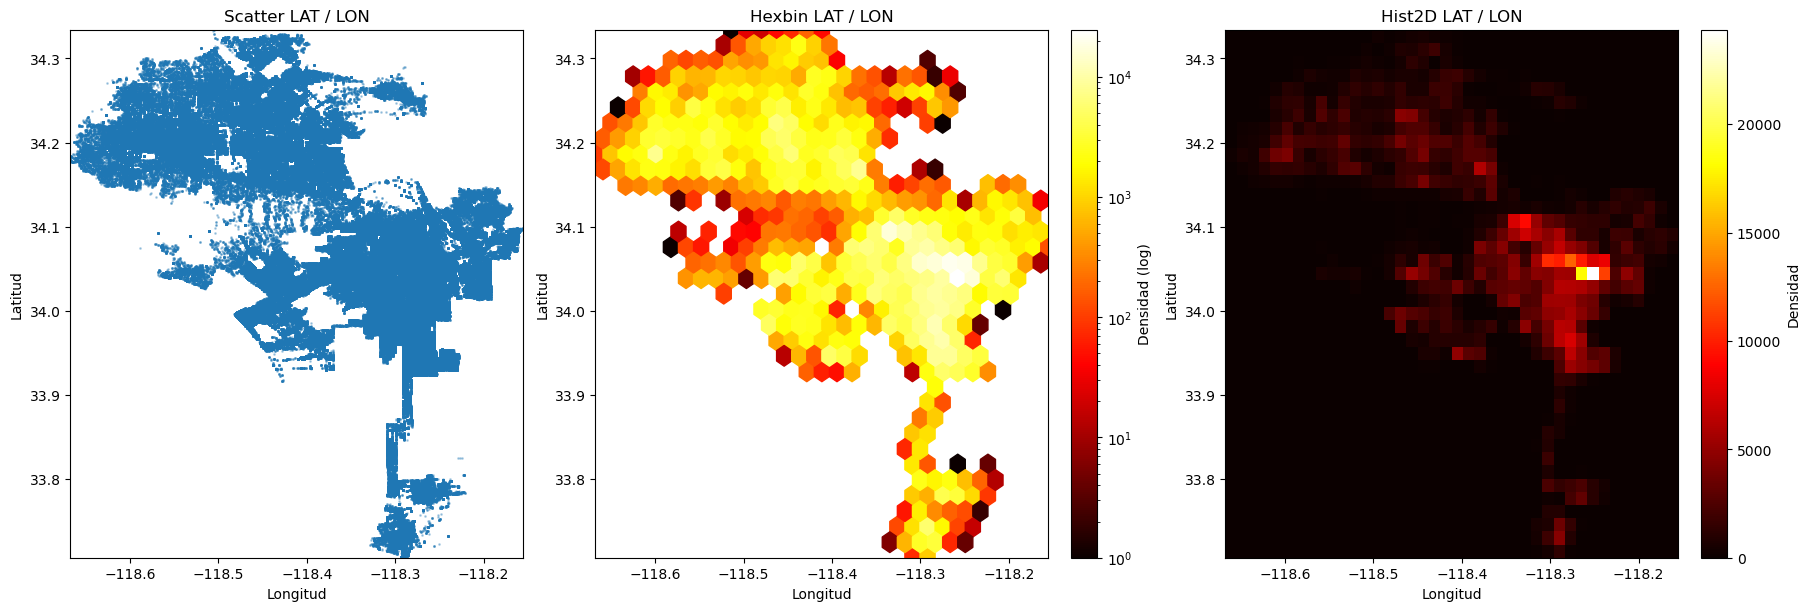

In [31]:
print("Mapa de Calor 1")
plot_latlon_comparativo(data)

In [33]:
top_crimes = data['Categoria_Delictiva'].value_counts().head(10).index
data_top = data[data['Categoria_Delictiva'].isin(top_crimes)].copy()

#### 5.Generacion de mapas de calor - Distribución espacial del delito selección de 10 de categorías

Mapa de Calor 2


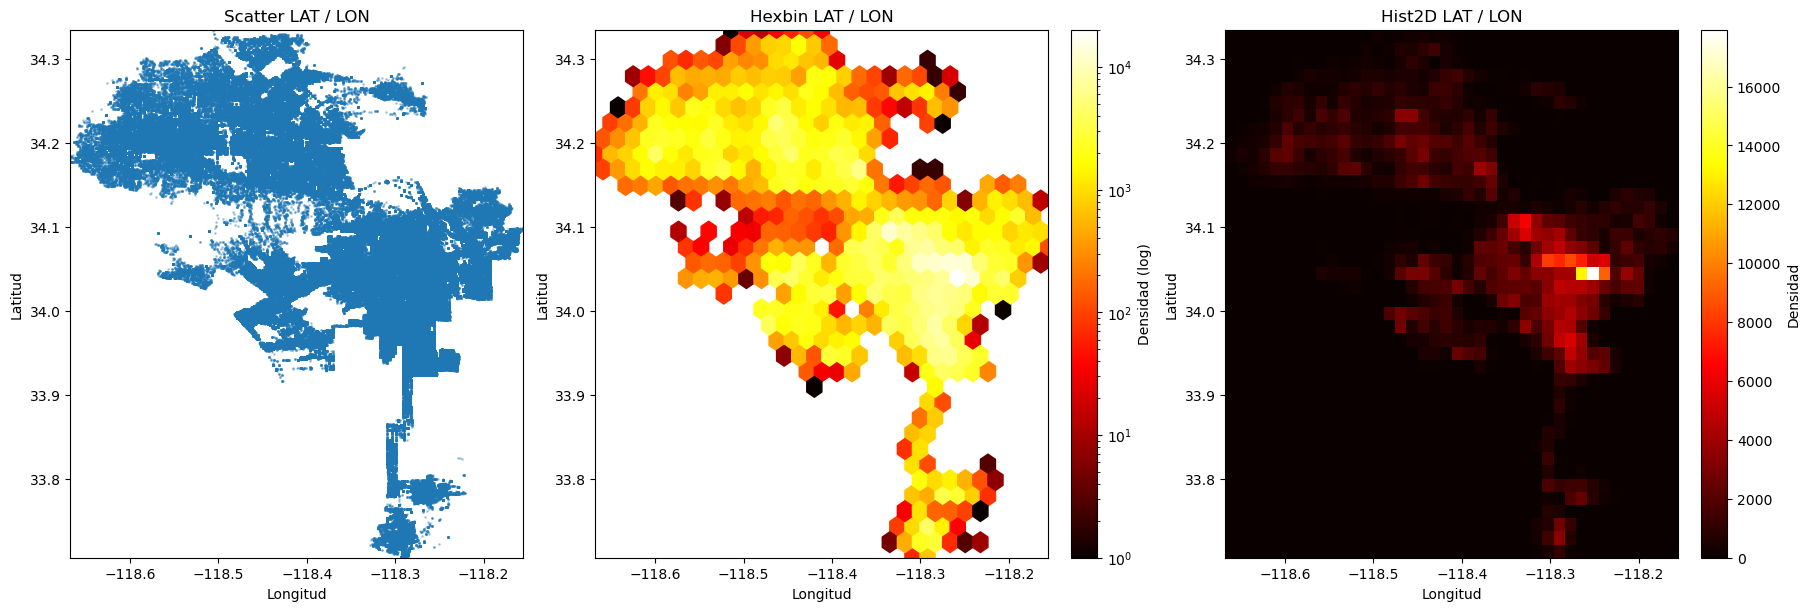

In [36]:
print("Mapa de Calor 2")
plot_latlon_comparativo(data_top)

#### 6. Ejecucion de los Modelos XGBoost y CatBoost

Ejecutado 1


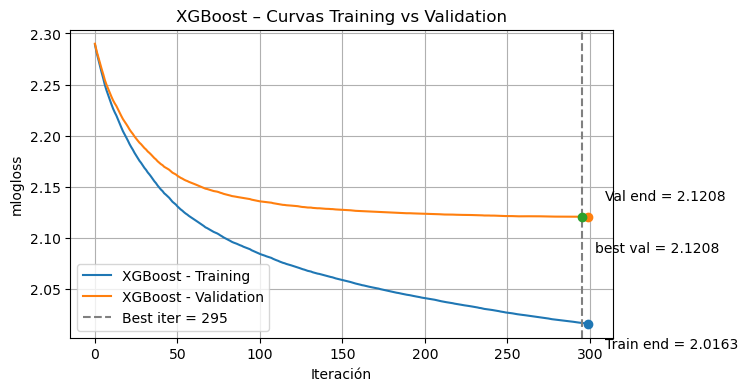

XGBoost entrenado XGBoost


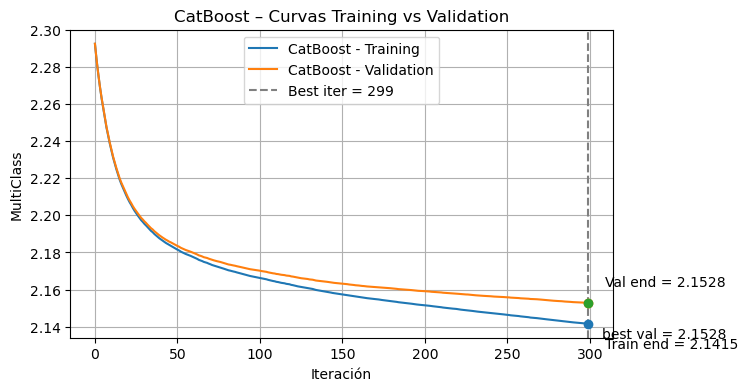

CatBoost entrenado  CatBoost
Modelos entrenados
Exportado a /models: xgb_model.joblib, cat_model.joblib, label_encoder.joblib 
Curvas guardadas: xgb_evals.joblib, cat_evals.joblib 


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from joblib import dump
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

# =========================
# Helper: anotar valores al final de curvas
# =========================
def annotate_endpoints(ax, y_train, y_val, label_train="Training", label_val="Validation",
                       fmt="{:.4f}", pad_pts=10, show_best=False, best_iter=None):
    """
    Anota el valor final (último punto) de training y validation.
    Opcional: anota el valor de validation en best_iter.
    """
    x_end = len(y_train) - 1

    # Últimos valores
    y_train_end = y_train[-1]
    y_val_end   = y_val[-1]

    # Puntos finales
    ax.scatter([x_end], [y_train_end], zorder=5)
    ax.scatter([x_end], [y_val_end], zorder=5)

    # Texto al final (ligero offset en pixeles)
    ax.annotate(f"{label_train} end = " + fmt.format(y_train_end),
                xy=(x_end, y_train_end),
                xytext=(pad_pts, -10),
                textcoords="offset points",
                ha="left", va="top")

    ax.annotate(f"{label_val} end = " + fmt.format(y_val_end),
                xy=(x_end, y_val_end),
                xytext=(pad_pts, +10),
                textcoords="offset points",
                ha="left", va="bottom")

    # Opcional: anotar best_iter en validation
    if show_best and best_iter is not None:
        best_iter = int(best_iter)
        y_best = y_val[best_iter]
        ax.scatter([best_iter], [y_best], zorder=6)
        ax.annotate("best val = " + fmt.format(y_best),
                    xy=(best_iter, y_best),
                    xytext=(10, -18),
                    textcoords="offset points",
                    ha="left", va="top")


# =========================
# 0) DATASET
# =========================
subset = data_top.query("latitud > 0 and longitud < 0")

cols_needed = ["latitud", "longitud", "hora_entera", "Categoria_Delictiva"]
subset_model = subset.dropna(subset=cols_needed).copy()

X = subset_model[["latitud", "longitud", "hora_entera"]].values
y_raw = subset_model["Categoria_Delictiva"]

le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Ejecutado 1")

# =========================
# 1) XGBOOST + CURVAS TRAIN/VAL
# =========================
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    verbose=False
)

# Curvas XGBoost
xgb_evals = xgb_model.evals_result_
xgb_train_loss = xgb_evals["validation_0"]["mlogloss"]
xgb_val_loss   = xgb_evals["validation_1"]["mlogloss"]
xgb_best_iter  = int(np.argmin(xgb_val_loss))

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(xgb_train_loss, label="XGBoost - Training")
ax.plot(xgb_val_loss,   label="XGBoost - Validation")
ax.axvline(xgb_best_iter, linestyle="--", color="gray", label=f"Best iter = {xgb_best_iter}")

# Anotar valores finales + best val
annotate_endpoints(
    ax,
    xgb_train_loss,
    xgb_val_loss,
    label_train="Train",
    label_val="Val",
    fmt="{:.4f}",
    pad_pts=12,
    show_best=True,
    best_iter=xgb_best_iter
)

ax.set_xlabel("Iteración")
ax.set_ylabel("mlogloss")
ax.set_title("XGBoost – Curvas Training vs Validation")
ax.legend()
ax.grid(True)
plt.show()

print("XGBoost entrenado XGBoost")

# =========================
# 2) CATBOOST + CURVAS TRAIN/VAL
# =========================
cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=300,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=False
)

cat_model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True,
    verbose=False
)

cat_evals = cat_model.get_evals_result()

metric_name = "MultiClass"
if metric_name not in cat_evals.get("learn", {}):
    metric_name = list(cat_evals.get("learn", {}).keys())[0]

cat_train_loss = cat_evals["learn"][metric_name]
cat_val_loss   = cat_evals["validation"][metric_name]
cat_best_iter  = int(np.argmin(cat_val_loss))

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(cat_train_loss, label="CatBoost - Training")
ax.plot(cat_val_loss,   label="CatBoost - Validation")
ax.axvline(cat_best_iter, linestyle="--", color="gray", label=f"Best iter = {cat_best_iter}")

# Anotar valores finales + best val
annotate_endpoints(
    ax,
    cat_train_loss,
    cat_val_loss,
    label_train="Train",
    label_val="Val",
    fmt="{:.4f}",
    pad_pts=12,
    show_best=True,
    best_iter=cat_best_iter
)

ax.set_xlabel("Iteración")
ax.set_ylabel(metric_name)
ax.set_title("CatBoost – Curvas Training vs Validation")
ax.legend()
ax.grid(True)
plt.show()

print("CatBoost entrenado  CatBoost")
print("Modelos entrenados")

# =========================
# 3) EXPORTAR A JOBLIB (Streamlit)
# =========================
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

dump(le, os.path.join(MODEL_DIR, "label_encoder.joblib"))
dump(xgb_model, os.path.join(MODEL_DIR, "xgb_model.joblib"))
dump(cat_model, os.path.join(MODEL_DIR, "cat_model.joblib"))

feature_cols = ["latitud", "longitud", "hora_entera"]
dump(feature_cols, os.path.join(MODEL_DIR, "feature_cols.joblib"))

dump(xgb_evals, os.path.join(MODEL_DIR, "xgb_evals.joblib"))
dump(cat_evals, os.path.join(MODEL_DIR, "cat_evals.joblib"))

print("Exportado a /models: xgb_model.joblib, cat_model.joblib, label_encoder.joblib ")
print("Curvas guardadas: xgb_evals.joblib, cat_evals.joblib ")

#### 6. Brier Score multiclase (TEST)

#### 1️⃣ Calculo de Brier Score multiclase.

In [41]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Probabilidades en TEST
probs_xgb = xgb_model.predict_proba(X_test)
probs_cat = cat_model.predict_proba(X_test)

# One-hot real
ohe = OneHotEncoder(sparse_output=False)
y_test_oh = ohe.fit_transform(y_test.reshape(-1, 1))


def brier_multiclass(y_true_oh, y_prob):
    return np.mean(np.sum((y_prob - y_true_oh) ** 2, axis=1))

brier_xgb = brier_multiclass(y_test_oh, probs_xgb)
brier_cat = brier_multiclass(y_test_oh, probs_cat)

print(f"Brier Score XGBoost: {brier_xgb:.4f}")
print(f"Brier Score CatBoost: {brier_cat:.4f}")


Brier Score XGBoost: 0.8575
Brier Score CatBoost: 0.8667


- 👉 Menor es mejor, porque indica que las probabilidades predichas están más cerca de los resultados reales.
- 📌 Conclusión numérica:XGBoost presenta una mejor calibración probabilística que CatBoost, aunque la diferencia sea moderada

#### 2️⃣ Curva de calibración (reliability diagram).
- 👉 En multiclase, lo correcto es usar la probabilidad máxima predicha (la que realmente usas para mapas de riesgo).
- 📌 Función genérica de calibración

In [44]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, model_name, n_bins=10):
    """
    Curva de calibración usando la probabilidad máxima predicha.
    """
    # Clase predicha y su probabilidad
    p_max = y_prob.max(axis=1)
    y_pred = y_prob.argmax(axis=1)

    # Acierto / error (1 si acierta, 0 si no)
    y_correct = (y_pred == y_true).astype(int)

    frac_pos, mean_pred = calibration_curve(
        y_correct, p_max, n_bins=n_bins, strategy="uniform"
    )

    plt.plot(mean_pred, frac_pos, marker="o", label=model_name)


#### 3️⃣ Graficar XGBoost vs CatBoost

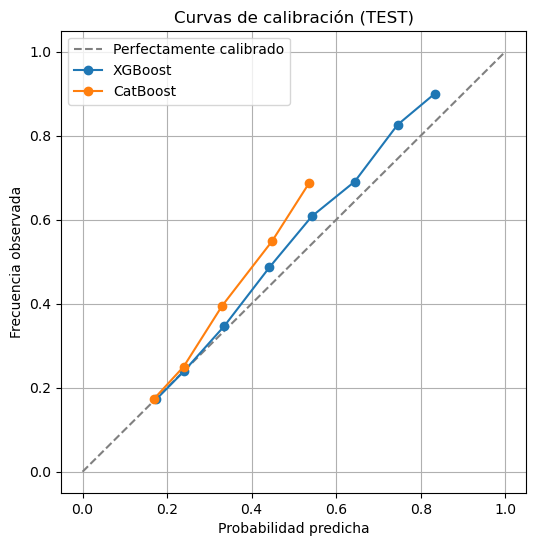

In [48]:
plt.figure(figsize=(6,6))

# Línea ideal
plt.plot([0,1], [0,1], "--", color="gray", label="Perfectamente calibrado")

plot_calibration_curve(y_test, probs_xgb, "XGBoost")
plot_calibration_curve(y_test, probs_cat, "CatBoost")

plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curvas de calibración (TEST)")
plt.legend()
plt.grid(True)
plt.show()


#### 7.Boxplot de probabilidades por clase (xgboost).


La evaluación del modelo se aborda desde dos perspectivas complementarias. La calibración permite verificar la fiabilidad global de las probabilidades estimadas, asegurando que los valores predichos se corresponden con las frecuencias observadas. Por su parte, el análisis de la distribución de probabilidades por categoría permite interpretar cómo el modelo reparte el riesgo entre los distintos tipos de delito, identificando aquellas categorías con patrones más definidos y aquellas caracterizadas por una mayor incertidumbre. La combinación de ambas evaluaciones ofrece una visión completa del comportamiento probabilístico del modelo.
“La calibración valida el valor numérico de la probabilidad; el boxplot explica su distribución y significado por delito.”

C:\Users\dimas\AppData\Local\Temp\ipykernel_79864\3543357114.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


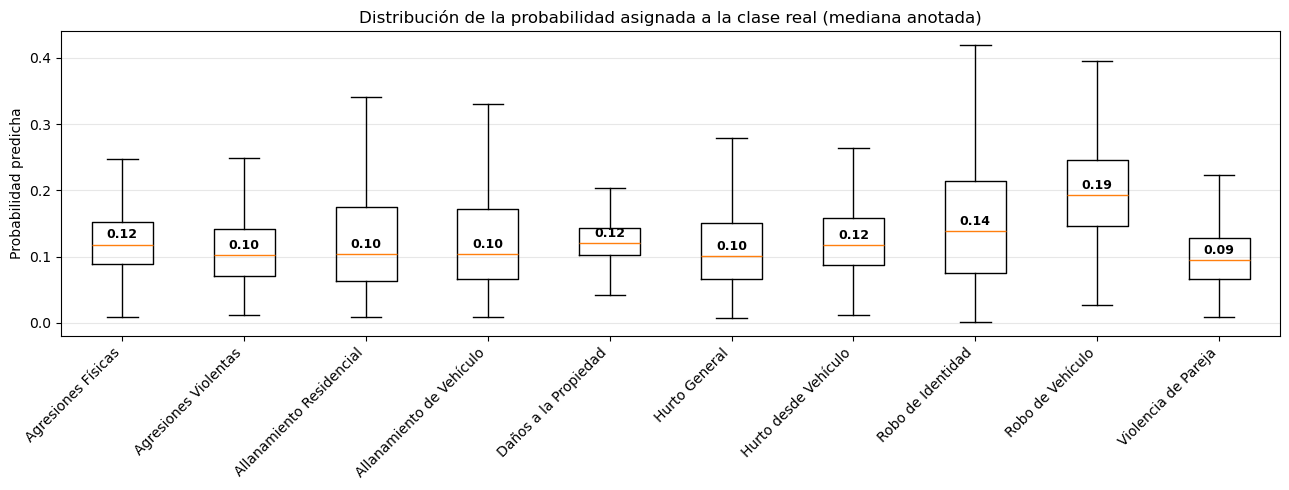

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def boxplot_probs_by_true_class_with_median(
    probs,
    y_true,
    class_names,
    min_n=200
):
    data = []
    labels = []
    medians = []

    for k, name in enumerate(class_names):
        p_k = probs[:, k]
        p_true = p_k[y_true == k]

        if len(p_true) >= min_n:
            data.append(p_true)
            labels.append(name)
            medians.append(np.median(p_true))

    fig, ax = plt.subplots(figsize=(13, 5))

    bp = ax.boxplot(
        data,
        labels=labels,
        showfliers=False
    )

    # Añadir valor numérico de la mediana
    for i, median in enumerate(medians):
        ax.text(
            i + 1,                 # posición x (boxplots empiezan en 1)
            median + 0.005,        # un poco encima de la mediana
            f"{median:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black",
            fontweight="bold"
        )

    ax.set_ylabel("Probabilidad predicha")
    ax.set_title("Distribución de la probabilidad asignada a la clase real (mediana anotada)")
    ax.grid(axis="y", alpha=0.3)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Guardar figura (recomendado)
    plt.savefig(
        "Figura_Boxplot_Probabilidades_XGBoost_Medianas.png",
        dpi=300,
        bbox_inches="tight"
    )

    plt.show()


# === Ejecutar ===
probs_xgb = xgb_model.predict_proba(X_test)

boxplot_probs_by_true_class_with_median(
    probs=probs_xgb,
    y_true=y_test,
    class_names=le.classes_,
    min_n=200
)



Se observa que delitos como Robo de Vehículo y Robo de Identidad presentan distribuciones desplazadas hacia valores más altos, lo que indica la existencia de patrones espacio-temporales más definidos. En contraste, categorías como Violencia de Pareja o Agresiones muestran probabilidades sistemáticamente más bajas, reflejando una mayor incertidumbre inherente al fenómeno y la limitada capacidad de discriminación con las variables consideradas. Este resultado explica el valor moderado de accuracy y refuerza la necesidad de evaluar el modelo desde una perspectiva probabilística, mediante métricas de calibración y análisis de la distribución del riesgo.

- “La accuracy evalúa etiquetas; el Brier Score evalúa probabilidades. Dado que el objetivo es analizar riesgo, la calibración probabilística es el criterio principal.”
- “La accuracy es baja porque el modelo no fuerza decisiones; el boxplot muestra que reparte el riesgo de forma coherente.”
- “La calibración valida el valor numérico de la probabilidad; el boxplot explica su distribución y significado por delito.”


#### 8.Evaluación Modelo XGBoost.

In [56]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import xgboost as xgb

# =========================
# PREDICCIÓN EN TEST USANDO "MEJOR ITERACIÓN"
# =========================

best_iter = xgb_best_iter  # ya lo calculaste con argmin(val_loss)

# Intento 1: sklearn wrapper (si tu versión soporta iteration_range)
try:
    y_proba_test_xgb = xgb_model.predict_proba(
        X_test,
        iteration_range=(0, best_iter + 1)
    )
except TypeError:
    # Intento 2: usar el Booster interno + DMatrix (compatibilidad)
    booster = xgb_model.get_booster()
    dtest = xgb.DMatrix(X_test)
    try:
        # versiones nuevas
        y_proba_test_xgb = booster.predict(dtest, iteration_range=(0, best_iter + 1))
    except TypeError:
        # versiones antiguas: ntree_limit espera "número de árboles"
        y_proba_test_xgb = booster.predict(dtest, ntree_limit=best_iter + 1)

# Predicción final
y_pred_test_xgb = y_proba_test_xgb.argmax(axis=1)

# Reporte
rep_xgb = classification_report(
    y_test, y_pred_test_xgb,
    target_names=le.classes_,
    output_dict=True,
    zero_division=0
)

df_rep_xgb = pd.DataFrame(rep_xgb).T
print(df_rep_xgb.round(4))

print("Accuracy XGBoost:", accuracy_score(y_test, y_pred_test_xgb))

                          precision  recall  f1-score      support
Agresiones Físicas           0.2186  0.1572    0.1829   15456.0000
Agresiones Violentas         0.2117  0.0975    0.1335   12601.0000
Allanamiento Residencial     0.2721  0.2278    0.2480   12361.0000
Allanamiento de Vehículo     0.2944  0.2178    0.2504   12834.0000
Daños a la Propiedad         0.1837  0.0787    0.1102   17761.0000
Hurto General                0.2419  0.1732    0.2018   12428.0000
Hurto desde Vehículo         0.1978  0.1185    0.1482   15806.0000
Robo de Identidad            0.2431  0.3742    0.2947   12502.0000
Robo de Vehículo             0.2323  0.5701    0.3301   26092.0000
Violencia de Pareja          0.1850  0.0571    0.0872   11828.0000
accuracy                     0.2333  0.2333    0.2333       0.2333
macro avg                    0.2281  0.2072    0.1987  149669.0000
weighted avg                 0.2263  0.2333    0.2066  149669.0000
Accuracy XGBoost: 0.23331484809813655


#### 9.Evaluación Modelo CatBoost.

In [59]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

# Predicción CatBoost
y_pred_Cat = cat_model.predict(X_test).reshape(-1)

# Asegura tipo entero (por si viene como float 3.0)
y_pred_Cat = y_pred_Cat.astype(int)

rep_cat = classification_report(
    y_test, y_pred_Cat,
    target_names=le.classes_,
    output_dict=True,
    zero_division=0
)

df_rep_cat = pd.DataFrame(rep_cat).T
print(df_rep_cat.round(4))

print("Accuracy CatBoost:", accuracy_score(y_test, y_pred_Cat))

                          precision  recall  f1-score      support
Agresiones Físicas           0.1957  0.0947    0.1276   15456.0000
Agresiones Violentas         0.2008  0.0376    0.0634   12601.0000
Allanamiento Residencial     0.2398  0.1764    0.2033   12361.0000
Allanamiento de Vehículo     0.2613  0.1852    0.2168   12834.0000
Daños a la Propiedad         0.1615  0.0349    0.0574   17761.0000
Hurto General                0.2118  0.1442    0.1716   12428.0000
Hurto desde Vehículo         0.1852  0.0462    0.0739   15806.0000
Robo de Identidad            0.2135  0.4170    0.2824   12502.0000
Robo de Vehículo             0.2178  0.6711    0.3288   26092.0000
Violencia de Pareja          0.2220  0.0109    0.0208   11828.0000
accuracy                     0.2171  0.2171    0.2171       0.2171
macro avg                    0.2109  0.1818    0.1546  149669.0000
weighted avg                 0.2090  0.2171    0.1653  149669.0000
Accuracy CatBoost: 0.217072339629449


#### 10.Tabla comparativa de métricas

In [62]:
from sklearn.metrics import f1_score

df_metrics = pd.DataFrame({
    "Modelo": ["XGBoost", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_test_xgb),
        accuracy_score(y_test, y_pred_Cat)
    ],
    "F1_macro": [
        f1_score(y_test, y_pred_test_xgb, average="macro"),
        f1_score(y_test, y_pred_Cat, average="macro")
    ],
    "F1_weighted": [
        f1_score(y_test, y_pred_test_xgb, average="weighted"),
        f1_score(y_test, y_pred_Cat, average="weighted")
    ]
}).round(4)

display(df_metrics)
print("Ejecutado 4 - Tabla comparativa de métricas")


Modelo  Accuracy  F1_macro  F1_weighted
0   XGBoost    0.2333    0.1987       0.2066
1  CatBoost    0.2171    0.1546       0.1653

Ejecutado 4 - Tabla comparativa de métricas


#### 11. Mini-mapas XGBoost (Top N, ordenados por riesgo).

Figura guardada en: minixgboost_hora22.jpg


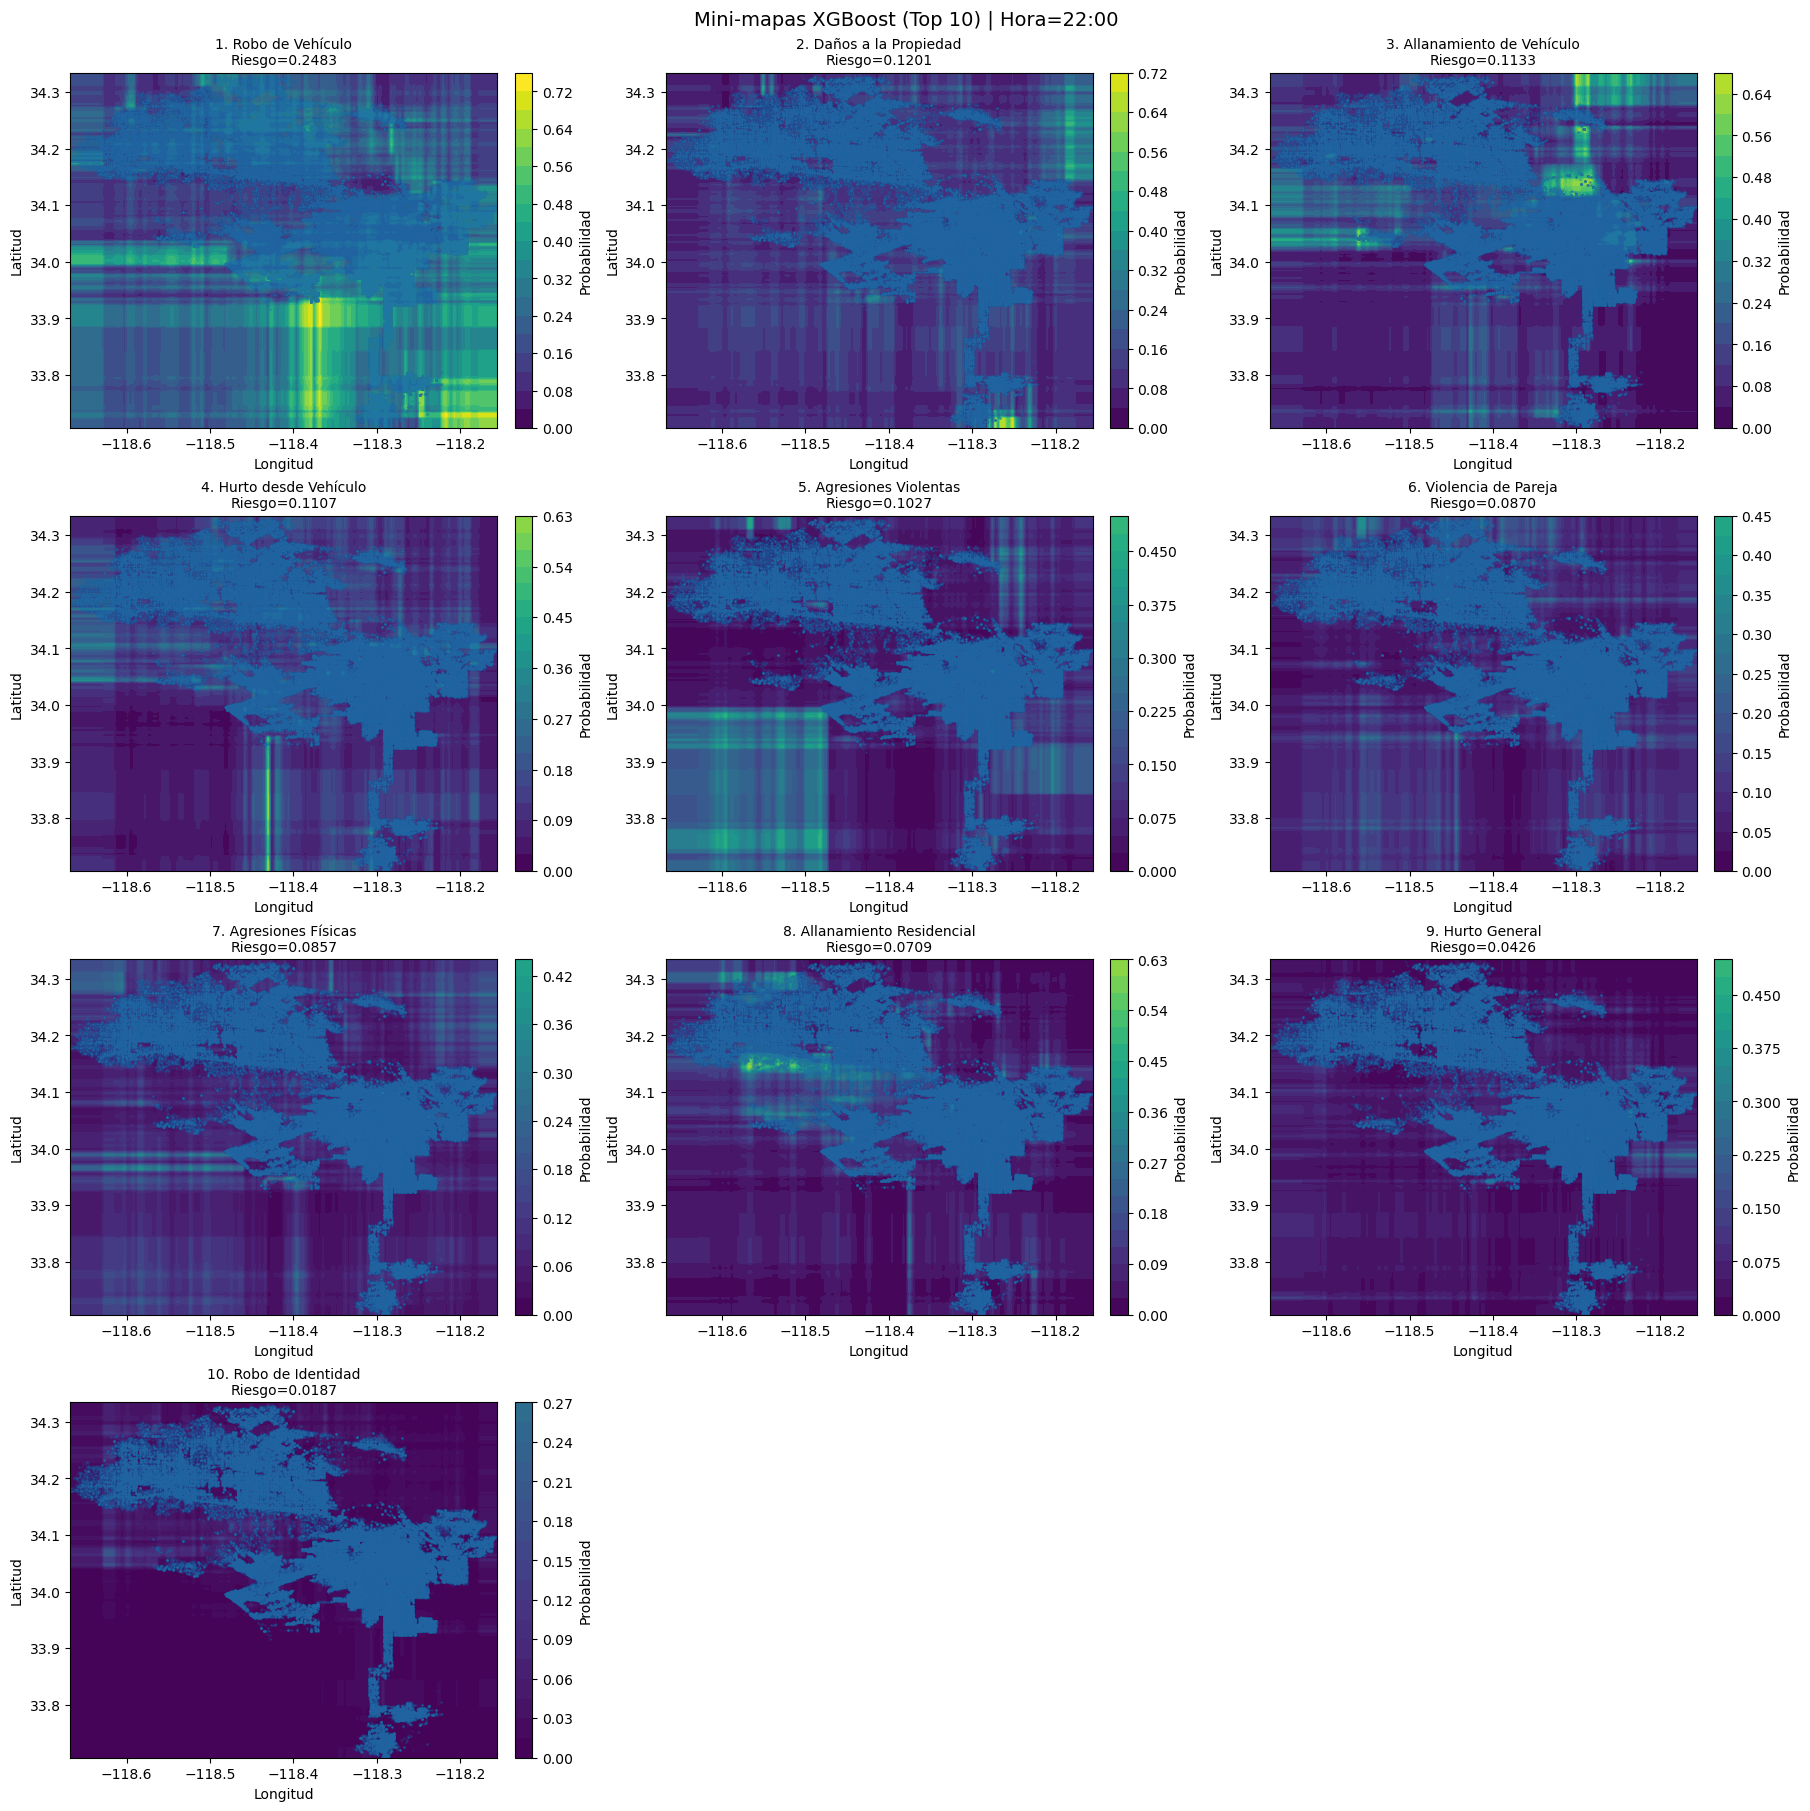

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# ====== CONFIG ======
hour_for_map = 22
n_bins = 150
topN = min(14, len(le.classes_))

# ====== GRID (misma zona) ======
lon_min, lon_max = subset_model["longitud"].min(), subset_model["longitud"].max()
lat_min, lat_max = subset_model["latitud"].min(), subset_model["latitud"].max()

grid_lon = np.linspace(lon_min, lon_max, n_bins)
grid_lat = np.linspace(lat_min, lat_max, n_bins)
grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

# OJO: tu modelo fue entrenado con [latitud, longitud, hora_entera]
grid_X = np.column_stack([
    grid_lat_mesh.ravel(),
    grid_lon_mesh.ravel(),
    np.full(grid_lon_mesh.size, hour_for_map)
])

# ====== PROBAS XGBoost en el grid (compatible con XGBClassifier) ======
best_iter = int(xgb_best_iter)

try:
    # versiones nuevas: iteration_range en predict_proba
    probs_xgb = xgb_model.predict_proba(grid_X, iteration_range=(0, best_iter + 1))
except TypeError:
    # fallback: usar Booster interno + DMatrix
    booster = xgb_model.get_booster()
    dgrid = xgb.DMatrix(grid_X)
    try:
        probs_xgb = booster.predict(dgrid, iteration_range=(0, best_iter + 1))
    except TypeError:
        probs_xgb = booster.predict(dgrid, ntree_limit=best_iter + 1)

# ====== RIESGO y ORDEN ======
risk_xgb = probs_xgb.mean(axis=0)
order_idx = np.argsort(risk_xgb)[::-1][:topN]

# ====== SUBPLOTS ======
n_cols = 3
n_rows = int(np.ceil(topN / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4.5 * n_rows),
    constrained_layout=True
)

axes = np.array(axes).ravel()

vmin = float(probs_xgb.min())
vmax = float(probs_xgb.max())

for rank, idx in enumerate(order_idx):
    ax = axes[rank]
    crime_label = le.classes_[idx]
    prob_grid = probs_xgb[:, idx].reshape(grid_lat_mesh.shape)

    im = ax.contourf(
        grid_lon_mesh, grid_lat_mesh, prob_grid,
        levels=20, vmin=vmin, vmax=vmax
    )

    ax.scatter(
        subset_model["longitud"], subset_model["latitud"],
        s=1, alpha=0.05
    )

    ax.set_title(f"{rank+1}. {crime_label}\nRiesgo={risk_xgb[idx]:.4f}", fontsize=10)
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Probabilidad")

# apagar ejes sobrantes
for j in range(topN, len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Mini-mapas XGBoost (Top {topN}) | Hora={hour_for_map}:00", fontsize=14)

# ====== GUARDAR (correcto: usando fig y ANTES de show) ======
output_path = f"minixgboost_hora{hour_for_map:02d}.jpg"
fig.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"Figura guardada en: {output_path}")

plt.show()



####  12.Mini-mapas CatBoost (Top N, ordenados por riesgo).

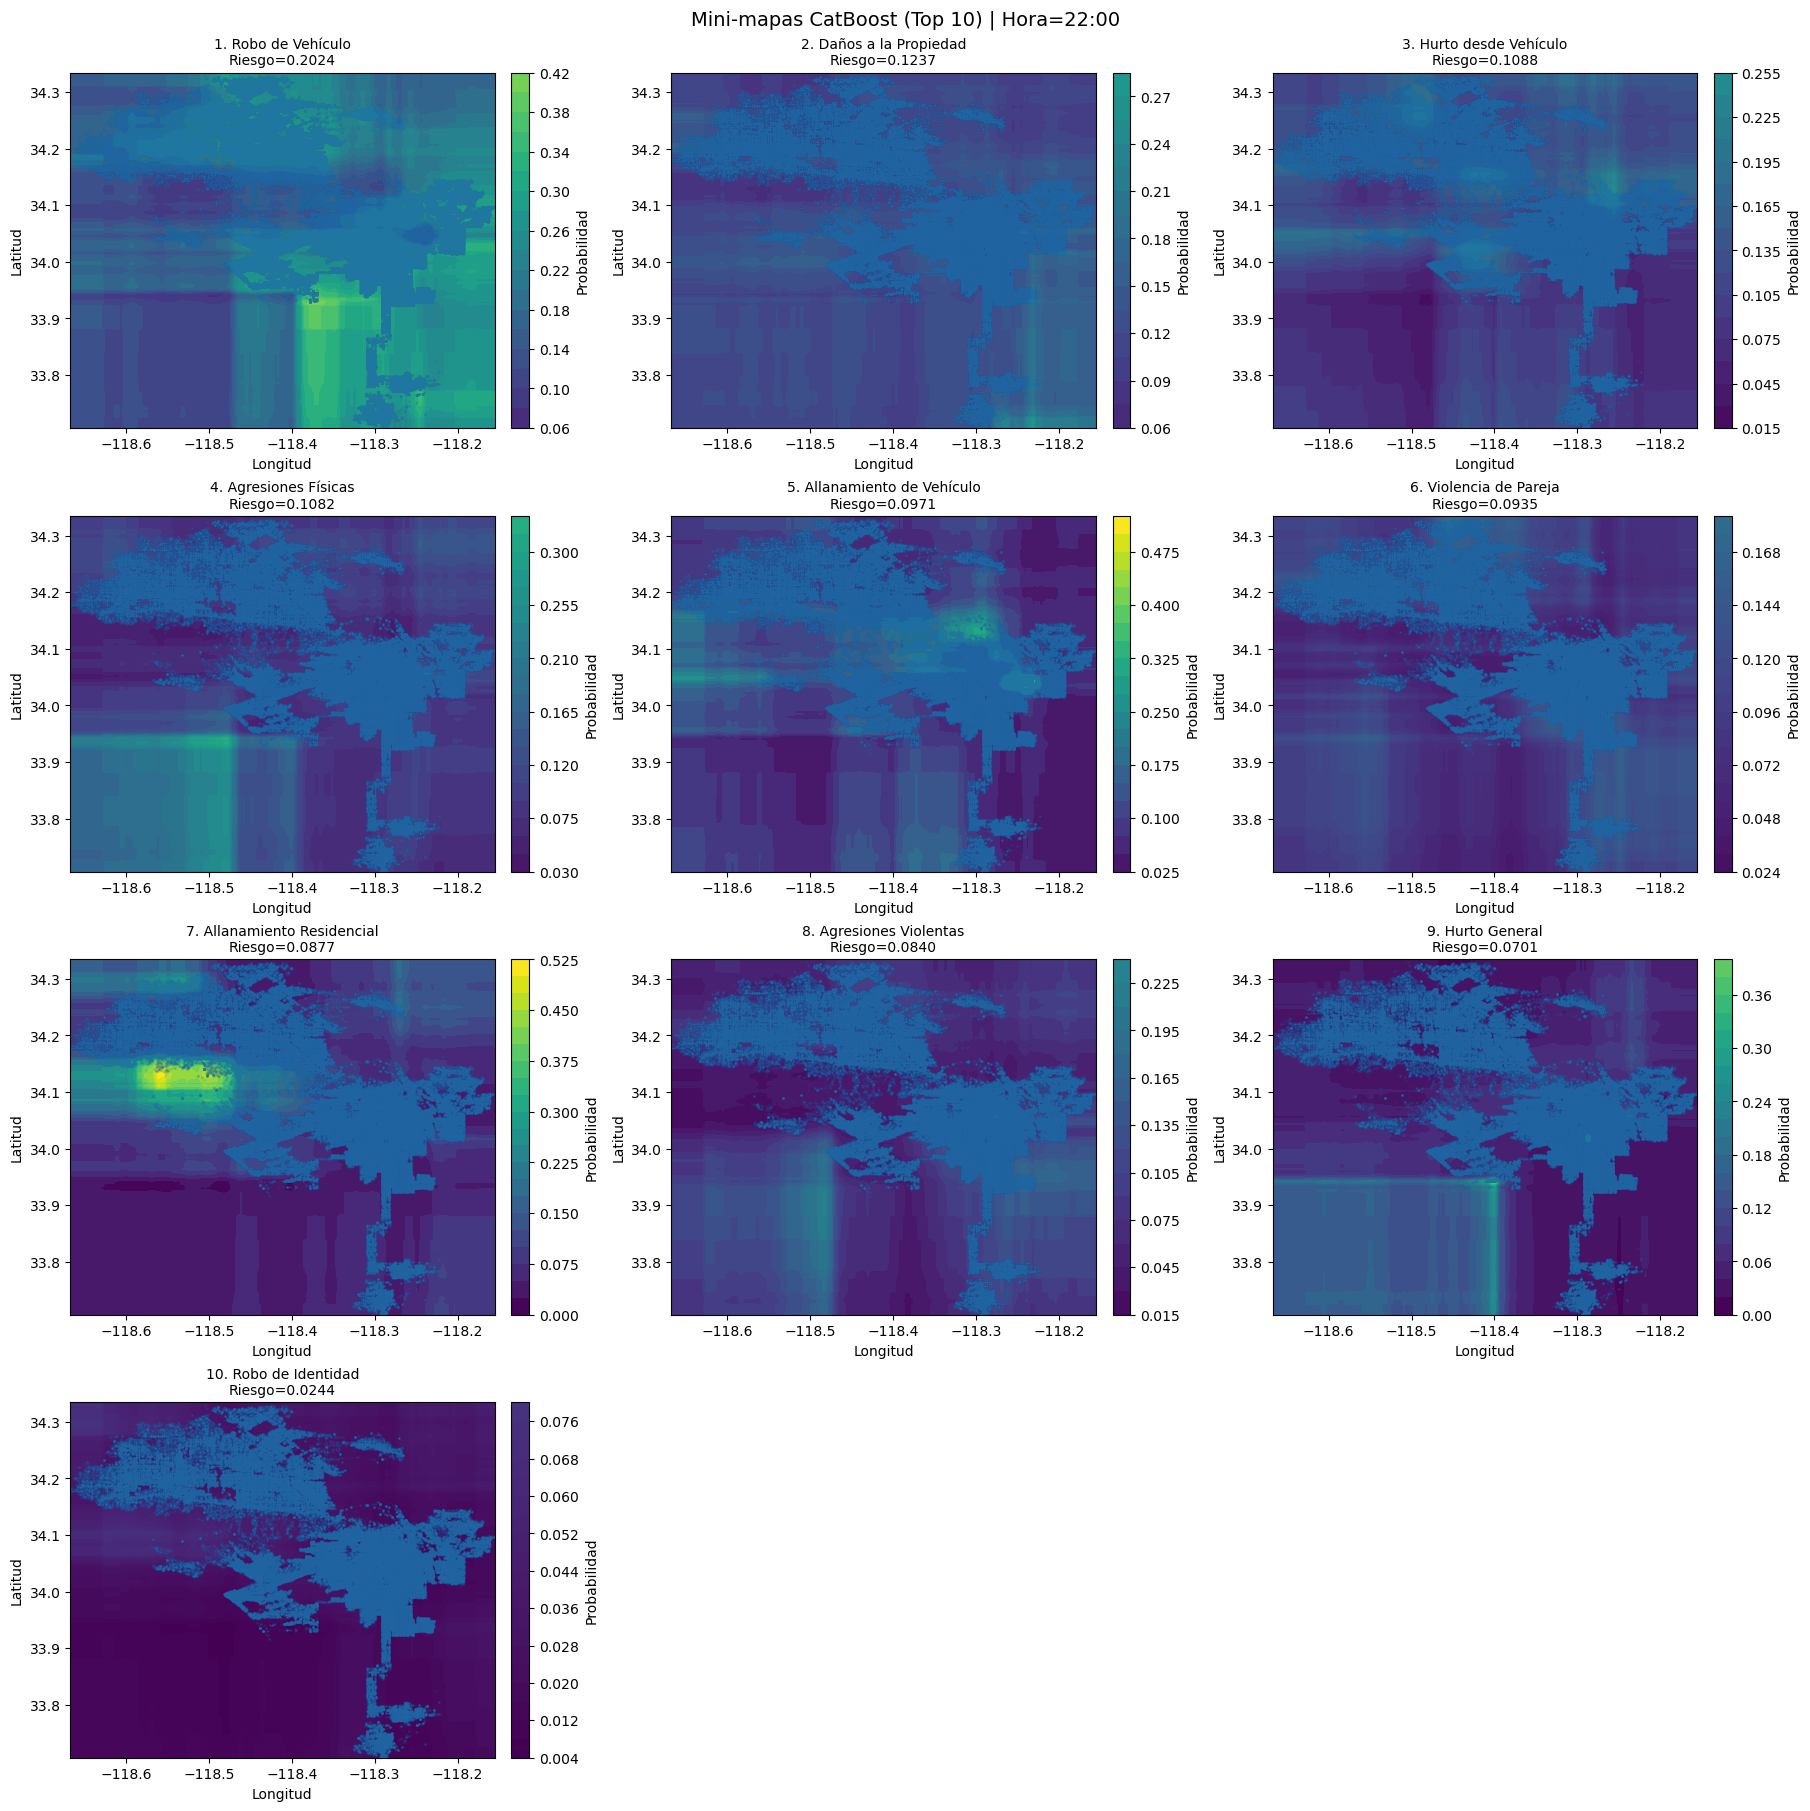

Ejecutado 6
Figura guardada en: minicatboost_top10_hora22.jpg


<Figure size 640x480 with 0 Axes>

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# ====== CONFIG ======
hour_for_map = 22
n_bins = 150
topN = min(10, len(le.classes_))

# ====== GRID (misma zona) ======
lon_min, lon_max = subset_model["longitud"].min(), subset_model["longitud"].max()
lat_min, lat_max = subset_model["latitud"].min(), subset_model["latitud"].max()

grid_lon = np.linspace(lon_min, lon_max, n_bins)
grid_lat = np.linspace(lat_min, lat_max, n_bins)
grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

grid_X = np.column_stack([
    grid_lat_mesh.ravel(),
    grid_lon_mesh.ravel(),
    np.full(grid_lon_mesh.size, hour_for_map)
])

# ====== PROBAS CatBoost en el grid ======
probs_cat = cat_model.predict_proba(grid_X)

# ====== RIESGO y ORDEN ======
risk_cat = probs_cat.mean(axis=0)
order_idx = np.argsort(risk_cat)[::-1][:topN]

# ====== SUBPLOTS ======
n_cols = 3
n_rows = int(np.ceil(topN / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4.5 * n_rows),
    constrained_layout=True
)
axes = np.array(axes).ravel()

vmin = float(probs_cat.min())
vmax = float(probs_cat.max())

for rank, idx in enumerate(order_idx):
    ax = axes[rank]
    crime_label = le.classes_[idx]
    prob_grid = probs_cat[:, idx].reshape(grid_lat_mesh.shape)

    im = ax.contourf(
        grid_lon_mesh, grid_lat_mesh, prob_grid,
        levels=20, vmin=vmin, vmax=vmax
    )

    ax.scatter(
        subset_model["longitud"], subset_model["latitud"],
        s=1, alpha=0.05
    )

    ax.set_title(f"{rank+1}. {crime_label}\nRiesgo={risk_cat[idx]:.4f}", fontsize=10)
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Probabilidad")

for j in range(topN, len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Mini-mapas CatBoost (Top {topN}) | Hora={hour_for_map}:00", fontsize=14)


plt.show()
print("Ejecutado 6")
##GUARDAR FIGURA
output_path = "minicatboost_top10_hora22.jpg"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"Figura guardada en: {output_path}")

#### 13. Comparacion de riesgos de los modelos

In [75]:
import pandas as pd

# ===== Risk scores XGBoost =====
# probs_xgb debe existir (salida del grid)
risk_scores_xgb = probs_xgb.mean(axis=0)

# ===== Risk scores CatBoost =====
# probs_cat debe existir (salida del grid)
risk_scores_cat = probs_cat.mean(axis=0)

df_risk = pd.DataFrame({
    "Delito": le.classes_,
    "Risk_XGBoost": risk_scores_xgb,
    "Risk_CatBoost": risk_scores_cat
})

df_risk["Rank_XGBoost"] = df_risk["Risk_XGBoost"].rank(
    ascending=False, method="min"
).astype(int)

df_risk["Rank_CatBoost"] = df_risk["Risk_CatBoost"].rank(
    ascending=False, method="min"
).astype(int)

df_risk["Delta_Cat_minus_XGB"] = (
    df_risk["Risk_CatBoost"] - df_risk["Risk_XGBoost"]
)

# ordenar por XGBoost (o por CatBoost si prefieres)
df_risk = df_risk.sort_values("Risk_XGBoost", ascending=False)
display(df_risk.round(4))

Delito  Risk_XGBoost  Risk_CatBoost  Rank_XGBoost  \
8          Robo de Vehículo        0.2483         0.2024             1   
4      Daños a la Propiedad        0.1201         0.1237             2   
3  Allanamiento de Vehículo        0.1133         0.0971             3   
6      Hurto desde Vehículo        0.1107         0.1088             4   
1      Agresiones Violentas        0.1027         0.0840             5   
9       Violencia de Pareja        0.0870         0.0935             6   
0        Agresiones Físicas        0.0857         0.1082             7   
2  Allanamiento Residencial        0.0709         0.0877             8   
5             Hurto General        0.0426         0.0701             9   
7         Robo de Identidad        0.0187         0.0244            10   

   Rank_CatBoost  Delta_Cat_minus_XGB  
8              1              -0.0459  
4              2               0.0037  
3              5              -0.0162  
6              3              -0.0018  
1              8              -0.0188  
9              6               0.0064  
0              4               0.0226  
2              7               0.0168  
5              9               0.0275  
7             10               0.0058

#### 14. Visualizacion del mapa

In [80]:
# ============================================================
# MAPA FOLIUM (TFM - TOOLTIP LIMPIO + TABLA COMPACTA):
# - Muestreo por área (hasta 500 puntos) para estimar prob. del modelo
# - Capas por hora (00-23) con radio-style (solo una activa)
# - Distrito SIEMPRE visible
# - Tooltip: SOLO modelo (Top-5 probabilidades) + N histórico total área + N histórico área,hora
# - SIN subcategorías
# - SIN conteos históricos por hora/categoría (para evitar confusión)
# ============================================================

import numpy as np
import pandas as pd
import folium
import branca.colormap as cm
from branca.element import MacroElement
from jinja2 import Template

# =========================
# CONFIG
# =========================
COL_LAT      = "latitud"
COL_LON      = "longitud"
COL_HOUR     = "hora_entera"

COL_AREA     = "area_nombre"
COL_DISTRICT = "distrito_policial"

DEFAULT_HOUR_SHOW = 12

SAMPLE_PER_AREA = 800
RANDOM_STATE = 42

RADIUS_MIN = 3
RADIUS_MAX = 9
FILL_OPACITY = 0.80

TOPK_MODEL = 10

OUTPUT_PATH = r"C:\Users\dimas\OneDrive\Escritorio\mapa_areas_xgboost_muestreo_tooltip_final.html"

# =========================
# 0) DATA
# =========================
df = subset_model.copy()

required = [COL_LAT, COL_LON, COL_AREA, COL_DISTRICT, COL_HOUR]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

df = df[
    df[COL_AREA].notna() & (df[COL_AREA].astype(str).str.strip() != "") &
    df[COL_DISTRICT].notna() & (df[COL_DISTRICT].astype(str).str.strip() != "")
].copy()

# limpiar distrito (340.0 -> 340)
def clean_district(v):
    s = str(v).strip()
    try:
        if s.endswith(".0"):
            return str(int(float(s)))
        return str(int(float(s))) if s.replace(".", "", 1).isdigit() else s
    except Exception:
        return s

df[COL_DISTRICT] = df[COL_DISTRICT].apply(clean_district)

# asegurar hora 0-23
df[COL_HOUR] = pd.to_numeric(df[COL_HOUR], errors="coerce").fillna(-1).astype(int)
df = df[(df[COL_HOUR] >= 0) & (df[COL_HOUR] <= 23)].copy()

print("Filas:", len(df))
print("Áreas únicas:", df[COL_AREA].nunique())

# =========================
# 1) MAPA BASE
# =========================
m = folium.Map(
    location=[float(df[COL_LAT].mean()), float(df[COL_LON].mean())],
    zoom_start=10,
    tiles="cartodbpositron",
    prefer_canvas=True
)

# =========================
# 2) Helper XGBoost
# =========================
def predict_proba_xgb_model(model, X, best_iter=None):
    if best_iter is None:
        return model.predict_proba(X)
    try:
        return model.predict_proba(X, iteration_range=(0, int(best_iter) + 1))
    except TypeError:
        return model.predict_proba(X)

try:
    BEST_ITER = int(xgb_best_iter)
except Exception:
    BEST_ITER = None

# =========================
# 3) Info por área (posición + N histórico total)
# =========================
area_info = (
    df.groupby(COL_AREA, as_index=False)
      .agg(
          lat=(COL_LAT, "mean"),
          lon=(COL_LON, "mean"),
          N_area_total=(COL_AREA, "size"),
          distrito=(COL_DISTRICT, lambda x: x.mode().iloc[0] if not x.mode().empty else "N/A")
      )
)
area_info_idx = area_info.set_index(COL_AREA)

# =========================
# 3.1) N histórico (área,hora) para tooltip
# =========================
area_hour_counts = (
    df.groupby([COL_AREA, COL_HOUR])
      .size()
      .reset_index(name="N_area_hour")
)
area_hour_dict = {(str(a), int(h)): int(n) for a, h, n in area_hour_counts.values}

# =========================
# 4) Muestreo por área (una sola vez)
# =========================
areas = df[COL_AREA].astype(str).unique().tolist()
sample_rows = []

for a in areas:
    g = df[df[COL_AREA].astype(str) == a]
    k = min(SAMPLE_PER_AREA, len(g))
    if k <= 0:
        continue
    take = g.sample(n=k, random_state=RANDOM_STATE)
    sample_rows.append(take[[COL_AREA, COL_LAT, COL_LON]])

sample_df = pd.concat(sample_rows, ignore_index=True)
print("Total puntos muestreados:", len(sample_df))

sample_area = sample_df[COL_AREA].astype(str).values
sample_lat  = sample_df[COL_LAT].astype(float).values
sample_lon  = sample_df[COL_LON].astype(float).values

# =========================
# 5) Etiqueta SIEMPRE visible: distrito
# =========================
def add_district_label(fg, lat, lon, distrito):
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(
            icon_size=(0, 0),
            icon_anchor=(0, 0),
            html=f"""
            <div style="
                font-size:11px;
                font-weight:700;
                color:#111;
                white-space:nowrap;
                pointer-events:none;
                transform: translate(6px, -6px);
                text-shadow: 0 0 2px rgba(255,255,255,0.95), 0 0 3px rgba(255,255,255,0.95);
            ">{distrito}</div>
            """
        )
    ).add_to(fg)

# =========================
# 6) CAPAS POR HORA
# =========================
for hour_for_map in range(24):

    fg = folium.FeatureGroup(
        name=f"Hora {hour_for_map:02d}:00",
        show=(hour_for_map == DEFAULT_HOUR_SHOW)
    ).add_to(m)

    # Predicción modelo sobre los puntos muestreados
    Xs = np.column_stack([sample_lat, sample_lon, np.full(len(sample_df), hour_for_map)])
    probs = predict_proba_xgb_model(xgb_model, Xs, best_iter=BEST_ITER)

    probs_df = pd.DataFrame(probs, columns=le.classes_)
    probs_df[COL_AREA] = sample_area
    mean_probs = probs_df.groupby(COL_AREA, as_index=True).mean()

    cat_dom = mean_probs.idxmax(axis=1)
    prob_max = mean_probs.max(axis=1)

    max_prob_hour = float(prob_max.max()) if len(prob_max) else 0.0
    colormap = cm.linear.Reds_09.scale(0, max_prob_hour if max_prob_hour > 0 else 1.0)

    for area_name, pmax in prob_max.items():
        area_name = str(area_name)
        if area_name not in area_info_idx.index:
            continue

        info = area_info_idx.loc[area_name]
        lat = float(info["lat"])
        lon = float(info["lon"])
        N_area_total = int(info["N_area_total"])
        distrito = str(info["distrito"])

        dom = str(cat_dom.loc[area_name])
        p   = float(pmax)

        #  N histórico (área,hora)
        N_area_hour = area_hour_dict.get((area_name, hour_for_map), 0)

        # Top-5 del modelo (solo probabilidades)
        vec = mean_probs.loc[area_name].values
        top_idx = np.argsort(-vec)[:TOPK_MODEL]
        top_rows = [(mean_probs.columns[j], float(vec[j])) for j in top_idx]

        # ---- TABLA TOP-5 MÁS COMPACTA ----
        tabla_model = """
        <b>Top categorías (modelo):</b>
        <table style="
            width:100%;
            border-collapse:collapse;
            font-size:11px;
            line-height:1.15;
        " border="1">
          <tr style="background-color:#f2f2f2;">
            <th style="padding:3px 6px; text-align:left;">Categoría</th>
            <th style="padding:3px 6px; text-align:right; width:70px;">Prob.</th>
          </tr>
        """
        for c, pv in top_rows:
            tabla_model += f"""
            <tr>
              <td style="padding:3px 6px;">{c}</td>
              <td style="padding:3px 6px; text-align:right;">{pv*100:.1f}%</td>
            </tr>
            """
        tabla_model += "</table>"

        # ---- TOOLTIP (MISMO ESTILO, SOLO + 1 FILA) ----
        tooltip_html = f"""
        <div style="width: 380px;">
          <h4 style="margin:0 0 6px 0;">Distrito: {distrito}</h4>
          <b>Área:</b> {area_name}<br>
          <b>Hora:</b> {hour_for_map:02d}:00<br>
          <b>Categoría dominante (modelo):</b> {dom}<br>
          <b>Probabilidad estimada (modelo):</b> {p*100:.1f}%<br>
          <b>N histórico total del área:</b> {N_area_total}<br>
          <b>N histórico (área,hora):</b> {N_area_hour}<br>
          <hr style="margin:8px 0;">
          {tabla_model}
        </div>
        """

        color = colormap(p)
        radius = RADIUS_MIN + (RADIUS_MAX - RADIUS_MIN) * (p / max_prob_hour) if max_prob_hour > 0 else RADIUS_MIN

        folium.CircleMarker(
            location=[lat, lon],
            radius=float(radius),
            color=color,
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=FILL_OPACITY,
            tooltip=folium.Tooltip(tooltip_html, sticky=True)
        ).add_to(fg)

        add_district_label(fg, lat, lon, distrito)

# =========================
# 7) LayerControl + Radio-style
# =========================
folium.LayerControl(collapsed=False).add_to(m)

class RadioLayerControl(MacroElement):
    _template = Template("""
    {% macro script(this, kwargs) %}
    (function() {
        function makeRadio() {
            var c = document.getElementsByClassName('leaflet-control-layers-overlays')[0];
            if (!c) return;
            var inputs = c.getElementsByTagName('input');
            for (var i = 0; i < inputs.length; i++) {
                inputs[i].addEventListener('change', function(e) {
                    if (e.target.checked) {
                        for (var j = 0; j < inputs.length; j++) {
                            if (inputs[j] !== e.target && inputs[j].checked) {
                                inputs[j].click();
                            }
                        }
                    }
                });
            }
        }
        setTimeout(makeRadio, 500);
    })();
    {% endmacro %}
    """)
m.get_root().add_child(RadioLayerControl())

# =========================
# 8) Guardar
# =========================
m.save(OUTPUT_PATH)
print("Mapa guardado en:", OUTPUT_PATH)
m

Filas: 748343
Áreas únicas: 21
Total puntos muestreados: 16800
Mapa guardado en: C:\Users\dimas\OneDrive\Escritorio\mapa_areas_xgboost_muestreo_tooltip_final.html


Justificación de las métricas empleadas

Aunque métricas clásicas como accuracy, precision, recall o F1-score son ampliamente utilizadas en problemas de clasificación, su aplicación resulta limitada en el contexto de este estudio. Estas métricas evalúan el rendimiento del modelo bajo un esquema de clasificación determinista, considerando únicamente la coincidencia entre la clase con mayor probabilidad y la categoría observada. Sin embargo, el objetivo del modelo propuesto no es asignar etiquetas únicas, sino estimar probabilidades que permitan analizar el riesgo delictivo de forma espacial y temporal.

En problemas multiclase con un elevado solapamiento entre categorías, como el analizado, la accuracy tiende a infraestimar la utilidad del modelo, ya que no captura la incertidumbre inherente al fenómeno ni evalúa la calidad de las probabilidades estimadas. Un modelo puede asignar probabilidades coherentes a varias categorías plausibles sin que la clase más probable coincida exactamente con la observada, lo que penaliza la accuracy sin reflejar un fallo real en la estimación del riesgo.

Por este motivo, la evaluación se apoya en métricas propiamente probabilísticas. En primer lugar, se emplea la calibración, que permite verificar que las probabilidades predichas son fiables en términos agregados, es decir, que valores similares de probabilidad se corresponden con frecuencias observadas similares. Para cuantificar esta fiabilidad se utiliza el Brier Score multiclase, una métrica adecuada para evaluar modelos probabilísticos, ya que penaliza tanto la sobreconfianza como la subestimación y mide directamente la distancia entre las probabilidades predichas y los resultados observados.

El uso del Brier Score resulta especialmente pertinente en este estudio, dado que el modelo genera mapas de riesgo basados en probabilidades continuas y no decisiones binarias. De forma complementaria, el análisis de la distribución de probabilidades por categoría mediante boxplots permite interpretar cómo el modelo reparte el riesgo entre los distintos tipos de delito, identificando aquellas categorías con patrones espacio-temporales más definidos y aquellas caracterizadas por una mayor incertidumbre.

En conjunto, mientras que la calibración y el Brier Score validan el significado numérico y la fiabilidad global de las probabilidades estimadas, los boxplots permiten analizar su comportamiento por categoría. Esta combinación proporciona una evaluación más coherente con el objetivo del estudio que el uso exclusivo de métricas de clasificación determinista como la accuracy.